<a href="https://colab.research.google.com/github/GuCuChiara/LSTM-NLP-classifier/blob/main/LSTM_NLP_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de texto usando LSTMs con TensorFlow 2.0

## Descargamos el dataset

Category classification, for news, is a multi-label text classification problem. 

The goal is to assign one or more categories to a news article. 

Get To Know Data:

We received data, which consists of 5 categories in total. 

The five categories we want to identify are Sports, Business, Politics, Tech, and Entertainment.

In [ ]:
!wget https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv

--2022-12-30 00:29:37--  https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/plain]
Saving to: ‘bbc-text.csv.1’

bbc-text.csv.1      100%[===================>]   4.82M  --.-KB/s    in 0.05s   

2022-12-30 00:29:37 (99.8 MB/s) - ‘bbc-text.csv.1’ saved [5057493/5057493]



## Importamos las librerías requeridas

**NLTK is a leading platform for building Python programs to work with human language data** 

It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries, and an active discussion forum.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

print(tf.__version__)

2.9.2


## Visualizamos el dataset

In [ ]:
df = pd.read_csv('bbc-text.csv')

In [ ]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [ ]:
print(STOPWORDS)

{'mightn', 'itself', 'the', 'he', 'is', 'have', 'were', "haven't", 'very', 'only', 'doing', 'to', 'such', 't', 'can', 'aren', 'against', 'how', 'themselves', 'will', 'at', 'so', 'been', 'where', 'below', 'your', 'these', "shan't", 'some', 'further', 'but', 'this', 'should', 'couldn', 'over', 've', 'ourselves', 'under', 'was', 'all', 'hadn', 'yourself', "needn't", 'his', "that'll", 'those', 'few', 'before', 'more', "mightn't", 'y', 'him', "wouldn't", 'off', 'during', 'once', 'than', 'again', 'doesn', 'we', 'are', "you'd", 'until', "aren't", 'wasn', 'what', 'own', 'who', 'a', "hadn't", "weren't", 'herself', 'for', 'yourselves', 'yours', 'any', 'by', 'it', 'm', 'has', 'about', "she's", 'now', 'its', 'theirs', "wasn't", 'hers', 'does', "don't", 'wouldn', 'that', 'our', 'most', 'weren', "you're", 'while', 'other', 're', 'nor', 'in', 'my', 'an', 'shan', 'no', 'ma', 'had', 'from', 'didn', 'ours', 'down', 'because', 'd', 'hasn', 'mustn', 'having', 'out', 'up', 'as', 'haven', 'on', "hasn't", 'h

## Creamos el dataset

In [ ]:
articles = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


## Definimos algunos parámetros de la red

In [ ]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post' # se añaden ceros al final hasta un máximo de 200
oov_tok = '<OOV>'
training_portion = .8

## Dividimos del dataset

In [ ]:
train_size = int(len(articles) * training_portion) #80% del total 

train_articles = articles[0: train_size] # entrenamiento = 0 :80%
train_labels = labels[0: train_size] 

validation_articles = articles[train_size:] # validación = 80% : hasta el final
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

1780
1780
1780
445
445


## Creamos el Tokenizador

**Tokenizer** assumes that the word tokens of the input texts have been delimited by whitespaces.

**Tokenizer provides the following functions:**

It will first create a dictionary for the entire corpus (a mapping of each word token and its unique integer index index) `(Tokenizer.fit_on_text())`

It can then use the corpus dictionary to convert words in each corpus text into integer sequences `(Tokenizer.texts_to_sequences())`

The dictionary is in `Tokenizer.word_index`

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])
 

{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'would': 4,
 'year': 5,
 'also': 6,
 'people': 7,
 'new': 8,
 'us': 9,
 'one': 10}

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[2431, 1, 225, 4995, 22, 641, 587, 225, 4995, 1, 1, 1662, 1, 1, 2431, 22, 564, 1, 1, 140, 278, 1, 140, 278, 796, 822, 662, 2307, 1, 1144, 1694, 1, 1721, 4996, 1, 1, 1, 1, 1, 4738, 1, 1, 122, 4514, 1, 2, 2874, 1505, 352, 4739, 1, 52, 341, 1, 352, 2171, 3961, 41, 22, 3794, 1, 1, 1, 1, 542, 1, 1, 1, 835, 631, 2366, 347, 4740, 1, 365, 22, 1, 787, 2367, 1, 4301, 138, 10, 1, 3663, 682, 3531, 1, 22, 1, 414, 822, 662, 1, 90, 13, 633, 1, 225, 4995, 1, 599, 1, 1694, 1021, 1, 4997, 807, 1864, 117, 1, 1, 1, 2974, 22, 1, 99, 278, 1, 1606, 4998, 542, 492, 1, 1443, 4741, 779, 1320, 1, 1861, 10, 33, 641, 319, 1, 62, 478, 564, 301, 1506, 22, 479, 1, 1, 1665, 1, 797, 1, 3066, 1, 1364, 6, 1, 2431, 564, 22, 2971, 4735, 1, 1, 1, 1, 1, 850, 39, 1825, 675, 297, 26, 979, 1, 882, 22, 361, 22, 13, 301, 1506, 1342, 374, 20, 63, 883, 1096, 4302, 247]


In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

425
200
192
200
186
200


In [ ]:
print(train_padded[10])

[2431    1  225 4995   22  641  587  225 4995    1    1 1662    1    1
 2431   22  564    1    1  140  278    1  140  278  796  822  662 2307
    1 1144 1694    1 1721 4996    1    1    1    1    1 4738    1    1
  122 4514    1    2 2874 1505  352 4739    1   52  341    1  352 2171
 3961   41   22 3794    1    1    1    1  542    1    1    1  835  631
 2366  347 4740    1  365   22    1  787 2367    1 4301  138   10    1
 3663  682 3531    1   22    1  414  822  662    1   90   13  633    1
  225 4995    1  599    1 1694 1021    1 4997  807 1864  117    1    1
    1 2974   22    1   99  278    1 1606 4998  542  492    1 1443 4741
  779 1320    1 1861   10   33  641  319    1   62  478  564  301 1506
   22  479    1    1 1665    1  797    1 3066    1 1364    6    1 2431
  564   22 2971 4735    1    1    1    1    1  850   39 1825  675  297
   26  979    1  882   22  361   22   13  301 1506 1342  374   20   63
  883 1096 4302  247    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 200)


## Codificamos las etiquetas (labels) usando el Tokenizador



In [ ]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

#imprimimos el número de labels:
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

berlin <OOV> anti nazi film german movie anti nazi <OOV> <OOV> drawn <OOV> <OOV> berlin film festival <OOV> <OOV> final days <OOV> final days member white rose movement <OOV> 21 arrested <OOV> brother hans <OOV> <OOV> <OOV> <OOV> <OOV> tyranny <OOV> <OOV> director marc <OOV> said feeling responsibility keep legacy <OOV> going must <OOV> keep ideas alive added film drew <OOV> <OOV> <OOV> <OOV> trial <OOV> <OOV> <OOV> east germany secret police discovery <OOV> behind film <OOV> worked closely <OOV> relatives including one <OOV> sisters ensure historical <OOV> film <OOV> members white rose <OOV> group first started <OOV> anti nazi <OOV> summer <OOV> arrested dropped <OOV> munich university calling day <OOV> <OOV> <OOV> regime film <OOV> six days <OOV> arrest intense trial saw <OOV> initially deny charges ended <OOV> appearance one three german films <OOV> top prize festival south african film version <OOV> <OOV> opera <OOV> shot <OOV> town <OOV> language also <OOV> berlin festival film en

## Construimos nuestra red neuronal

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim), #5000 vocab_size * 64 embeddind_dim = 320000
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), #64 embeddind_dim
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Entrenamos nuestro modelo

In [ ]:
num_epochs = 5
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/5
56/56 - 12s - loss: 0.2713 - accuracy: 0.9270 - val_loss: 0.3386 - val_accuracy: 0.8854 - 12s/epoch - 215ms/step
Epoch 2/5
56/56 - 11s - loss: 0.1058 - accuracy: 0.9685 - val_loss: 0.3260 - val_accuracy: 0.9101 - 11s/epoch - 200ms/step
Epoch 3/5
56/56 - 11s - loss: 0.0574 - accuracy: 0.9843 - val_loss: 0.3998 - val_accuracy: 0.9101 - 11s/epoch - 199ms/step
Epoch 4/5
56/56 - 11s - loss: 0.0686 - accuracy: 0.9831 - val_loss: 0.3321 - val_accuracy: 0.8944 - 11s/epoch - 203ms/step
Epoch 5/5
56/56 - 11s - loss: 0.0345 - accuracy: 0.9888 - val_loss: 0.2973 - val_accuracy: 0.9191 - 11s/epoch - 199ms/step


## Visualizamos los resultados

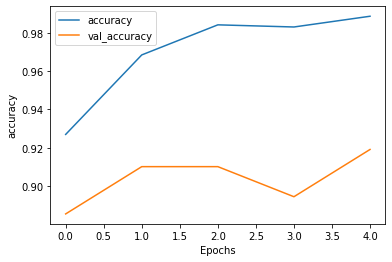

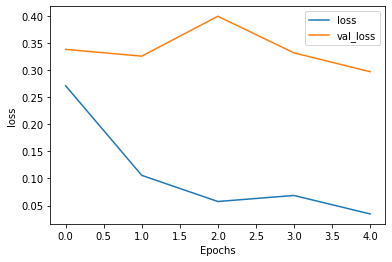

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Probemos nuestro modelo

In [ ]:
import pprint
#txt = ["Stock market news live updates: S&P 500 rises to record close, Dow up 272 points ahead of July jobs report."]
# txt = ["Traditionally, bitcoin trading has involved the buying and selling of the cryptocurrency on an exchange."]
txt=["Barack Hussein Obama II is an American politician who served as the 44th president of the United States from 2009 to 2017."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
print('Predicción\n')
pprint.pprint(pred)
print()
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
#labels = ['1', '2', '3', '4', '5', '6']
print(txt[0])
print(' => ' + labels[np.argmax(pred)])

1/1 [==============================] - 0s 34ms/step
Predicción

array([[1.9822946e-06, 9.9685657e-01, 1.0824954e-06, 6.1790540e-04,
        2.0437953e-03, 4.7854971e-04]], dtype=float32)

Barack Hussein Obama II is an American politician who served as the 44th president of the United States from 2009 to 2017.
 => bussiness


In [ ]:
#txt = ["Stock market news live updates: S&P 500 rises to record close, Dow up 272 points ahead of July jobs report."]
txt = ["After a glorious night of football at the Lusail Stadium in Doha, Lionel Messi finally got his chance to lift the Fifa World Cup trophy."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
print(txt[0] + ' => ' + labels[np.argmax(pred)])

1/1 [==============================] - 0s 34ms/step
After a glorious night of football at the Lusail Stadium in Doha, Lionel Messi finally got his chance to lift the Fifa World Cup trophy. => bussiness


In [ ]:
import pprint
#txt = ["Stock market news live updates: S&P 500 rises to record close, Dow up 272 points ahead of July jobs report."]
txt = ["The Way of Water is a 2022 American epic science fiction film directed by James Cameron, who co-wrote the screenplay with Rick Jaffa."]
#txt=["Barack Hussein Obama II is an American politician who served as the 44th president of the United States from 2009 to 2017."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
print('Predicción\n')
pprint.pprint(pred)
print()
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
#labels = ['1', '2', '3', '4', '5', '6']
print(txt[0] + ' => ' + labels[np.argmax(pred)])

1/1 [==============================] - 0s 39ms/step
Predicción

array([[1.9475133e-06, 9.9683976e-01, 1.0812349e-06, 6.1522162e-04,
        2.0590085e-03, 4.8302909e-04]], dtype=float32)

The Way of Water is a 2022 American epic science fiction film directed by James Cameron, who co-wrote the screenplay with Rick Jaffa. => bussiness
